<a href="https://colab.research.google.com/github/MasahitoKatsuki/RabbitChallenge/blob/main/handson2_3_batch_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [2]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')
sys.path.append('/content/drive/My Drive/DNN_code/lesson_2')

# batch normalization

In [3]:
import numpy as np
from collections import OrderedDict
from common import layers
from data.mnist import load_mnist
import matplotlib.pyplot as plt
from multi_layer_net import MultiLayerNet
from common import optimizer

# バッチ正則化 layer
class BatchNormalization:
    '''
    gamma: スケール係数
    beta: オフセット
    momentum: 慣性
    running_mean: テスト時に使用する平均
    running_var: テスト時に使用する分散
    '''
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None

        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward時に使用する中間データ
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0) # 平均
            xc = x - mu # xをセンタリング
            var = np.mean(xc**2, axis=0) # 分散
            std = np.sqrt(var + 10e-7) # スケーリング
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu # 平均値の加重平均
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var #分散値の加重平均
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        
        return out

    def backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx    


データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.16
                : 10. 正答率(テスト) = 0.1421
Generation: 20. 正答率(トレーニング) = 0.12
                : 20. 正答率(テスト) = 0.1666
Generation: 30. 正答率(トレーニング) = 0.2
                : 30. 正答率(テスト) = 0.1868
Generation: 40. 正答率(トレーニング) = 0.22
                : 40. 正答率(テスト) = 0.2133
Generation: 50. 正答率(トレーニング) = 0.2
                : 50. 正答率(テスト) = 0.2368
Generation: 60. 正答率(トレーニング) = 0.24
                : 60. 正答率(テスト) = 0.2666
Generation: 70. 正答率(トレーニング) = 0.3
                : 70. 正答率(テスト) = 0.2948
Generation: 80. 正答率(トレーニング) = 0.22
                : 80. 正答率(テスト) = 0.3352
Generation: 90. 正答率(トレーニング) = 0.34
                : 90. 正答率(テスト) = 0.3887
Generation: 100. 正答率(トレーニング) = 0.42
                : 100. 正答率(テスト) = 0.4379
Generation: 110. 正答率(トレーニング) = 0.48
                : 110. 正答率(テスト) = 0.473
Generation: 120. 正答率(トレーニング) = 0.5
                : 120. 正答率(テスト) = 0.4987
Generation: 130. 正答率(トレーニング) = 0.51
                : 130. 正答率(テスト) = 0.5241
Generation: 

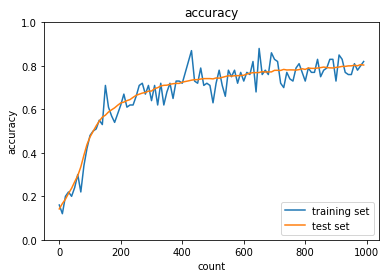

In [4]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")


# batch_normalizationの設定 =======================
use_batchnorm = True
# use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
                        activation='sigmoid', weight_init_std='Xavier', use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.01

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]

        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)        
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
                

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] 活性化関数や重みの初期値を変えてみよう
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.35
                : 10. 正答率(テスト) = 0.3353
Generation: 20. 正答率(トレーニング) = 0.58
                : 20. 正答率(テスト) = 0.5529
Generation: 30. 正答率(トレーニング) = 0.59
                : 30. 正答率(テスト) = 0.602
Generation: 40. 正答率(トレーニング) = 0.73
                : 40. 正答率(テスト) = 0.6451
Generation: 50. 正答率(トレーニング) = 0.76
                : 50. 正答率(テスト) = 0.6527
Generation: 60. 正答率(トレーニング) = 0.76
                : 60. 正答率(テスト) = 0.6662
Generation: 70. 正答率(トレーニング) = 0.65
                : 70. 正答率(テスト) = 0.697
Generation: 80. 正答率(トレーニング) = 0.63
                : 80. 正答率(テスト) = 0.7162
Generation: 90. 正答率(トレーニング) = 0.69
                : 90. 正答率(テスト) = 0.6921
Generation: 100. 正答率(トレーニング) = 0.76
                : 100. 正答率(テスト) = 0.678
Generation: 110. 正答率(トレーニング) = 0.74
                : 110. 正答率(テスト) = 0.6987
Generation: 120. 正答率(トレーニング) = 0.73
                : 120. 正答率(テスト) = 0.7085
Generation: 130. 正答率(トレーニング) = 0.73
                : 130. 正答率(テスト) = 0.7196
Generation

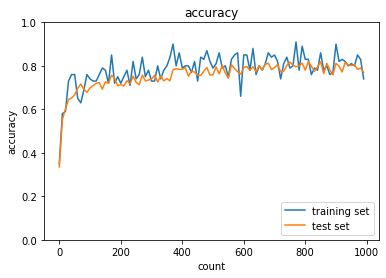

In [7]:
#中間層が５層にしてみた。その分計算コストがかかる。
#そのため、学習率を0.01から0.1にすると学習がより早く進行させる。
#同様の条件で初期値をランダムにしても（XavierやHeの初期値を使用しなくても）学習が進んだ。
#トータルとして計算も速く、精度も高くなった。

(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")


# batch_normalizationの設定 =======================
# use_batchnorm = True
use_batchnorm = True
# ====================================================

# network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
#                         activation='sigmoid', weight_init_std='Xavier', use_batchnorm=use_batchnorm)
# network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10,
#                         activation='relu', weight_init_std='He', use_batchnorm=use_batchnorm)
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 40, 40, 40, 20], output_size=10, #5層にしている
                       activation='relu', weight_init_std=0.01, use_batchnorm=use_batchnorm) #バッチ正規化を行い、かつ初期値はHeやXavierを用いていない。


iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate= 0.1 #0.01から0.1にすることでゆっくりではなく早めに学習させている。ただし、発散しないように注意必要。

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network.params[key] -= learning_rate * grad[key]

        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)        
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
                

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()